Jakob Balkovec, Thu Jun 26th 2025

In [92]:
import cv2
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pathlib import Path

import json

# ======
from lesion_parser import LesionXMLParser
from utils import parse_txt_file
# ======


## Configuration

In [ ]:
PATCH_HALF = 12 # since patches are 25x25
PATCH_SIZE = 25
PATCH_ROOT = Path("../data/patches")
DATA_ROOT = Path("../data/raw")


Just defining constants...

In [94]:
def plot_lesion_annotations(image, lesions, title=None):
    plt.figure(figsize=(12, 12))
    plt.imshow(image)

    for lesion in lesions:
        x, y = int(lesion["x"]), int(lesion["y"])
        lesion_type = lesion["type"]

        rect = plt.Rectangle((x - PATCH_HALF, y - PATCH_HALF), PATCH_SIZE, PATCH_SIZE,
                             linewidth=1.5, edgecolor='lime', facecolor='none')
        plt.gca().add_patch(rect)

        plt.plot(x, y, 'ro', markersize=3)
        plt.text(x + 2, y + 2, lesion_type, color='yellow', fontsize=8)

    plt.title(title or f"{len(lesions)} annotated lesions", fontsize=14)
    plt.axis("off")
    plt.show()

def extract_patches(image, image_shape, lesions):
    patches = []
    for lesion in lesions:
        x, y = int(lesion["x"]), int(lesion["y"])
        x1, y1 = x - PATCH_HALF, y - PATCH_HALF
        x2, y2 = x1 + PATCH_SIZE, y1 + PATCH_SIZE

        if x1 < 0 or y1 < 0 or x2 > image_shape[1] or y2 > image_shape[0]:
            continue

        patch = image[y1:y2, x1:x2]
        if patch.shape[:2] == (PATCH_SIZE, PATCH_SIZE):
            patches.append((patch, lesion["type"]))
    return patches

def plot_patches(patches, title="Extracted 25x25 Lesion Patches"):
    n = len(patches)
    cols = 5
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(15, 3 * rows))
    for i, (patch, label) in enumerate(patches):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(patch)
        plt.title(label, fontsize=15)
        plt.axis("off")

    plt.suptitle(title, fontsize=25, y=1.00)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


Utility functions...

## Algorithm to "Merge" the Annotations

In [43]:
from collections import Counter
from sklearn.cluster import DBSCAN
import numpy as np

def fuse_annotations(lesions, eps=5, min_samples=1):
    # pre: lesions (list of dicts with 'x', 'y', 'type', ...)
    # post: deduplicated list of lesion dicts (one per cluster)
    # desc: merges overlapping annotations using DBSCAN clustering

    # note: eps sets max distance for duplicates
    # note: type is resolved by majority vote

    coords = np.array([[l['x'], l['y']] for l in lesions])
    types = [l['type'] for l in lesions]

    # cluster close annotations
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    labels = clustering.labels_

    fused_lesions = []
    for cluster_id in np.unique(labels):
        indices = np.where(labels == cluster_id)[0]
        cluster_coords = coords[indices]
        cluster_types = [types[i] for i in indices]

        # avg coordinates
        x_avg, y_avg = np.mean(cluster_coords, axis=0)

        # radius = average or max from cluster
        radii = [lesions[i].get("radius", 5) or 5 for i in indices]
        r_avg = float(np.mean(radii))

        # majority vote
        type_counts = Counter(cluster_types)
        top_type = type_counts.most_common(1)[0][0]

        base = dict(lesions[indices[0]])
        base.update({"x": x_avg, "y": y_avg, "radius": r_avg, "type": top_type})
        fused_lesions.append(base)

    return fused_lesions


**Initial Approach**

I was thinking about just using a `set` to remove duplicates. Since the `XMLParser` retunrs a list, a simple cast would've been enough to remove duplicates. However, the "dupliactes" were not exact duplicates, the `x` and `y` coordinates were slightly different


**DBSCAN Approach**

I created this function after plotting all the annotations from all the XML files. 

I saw there were some duplicates and some were overlapping eachother. Since I wanted to clean this up a little bit, I wrote this simple function to merge annotations that are close together into a single representative annotation. I don't think this could be the final algorithm we use, but it could be a good starting point for further development...

**How it works**

The function uses [`DBSCAN`](https://www.geeksforgeeks.org/machine-learning/dbscan-clustering-in-ml-density-based-clustering/) clustering to group lesion annotations that are spatially close together (within `eps` pixels). 

> Note: This is my first time using about `DBSCAN`, I tried using `k-means` but it didn't really work that well, after searching for some alternatives, I stumbled upon `DBSCAN`. If you find a better approach please let me know...

For each cluster, it averages the `x` and `y` coordinates, averages the `radius` values, and uses a majority vote to pick the most common lesion type. It then returns one clean, representative annotation per cluster.

In [60]:
parsed_text_input = parse_txt_file("../data/raw/ddb1_v02_01_test_plain.txt")
single_entry = parsed_text_input[0]  # first image + all the XML files

print(json.dumps(single_entry, indent=2))

# @see XMLParser
parser = LesionXMLParser(xml_input=[single_entry], root_dir=DATA_ROOT)
lesions = parser.parse()

# sanity check
pd_frame = parser.to_format("pandas")
print(pd_frame.head())

lesions = fuse_annotations(lesions, eps=5) # note that we're starting with 5


{
  "image": "images/diaretdb1_image002.png",
  "xmls": [
    "groundtruth/diaretdb1_image002_01_plain.xml",
    "groundtruth/diaretdb1_image002_02_plain.xml",
    "groundtruth/diaretdb1_image002_03_plain.xml",
    "groundtruth/diaretdb1_image002_04_plain.xml"
  ]
}
                      image_path            image_id  \
0  images/diaretdb1_image002.png  diaretdb1_image002   
1  images/diaretdb1_image002.png  diaretdb1_image002   
2  images/diaretdb1_image002.png  diaretdb1_image002   
3  images/diaretdb1_image002.png  diaretdb1_image002   
4  images/diaretdb1_image002.png  diaretdb1_image002   

                          xml_file          type       x      y  radius  
0  diaretdb1_image002_01_plain.xml  Haemorrhages   570.0  805.0    16.0  
1  diaretdb1_image002_01_plain.xml  Haemorrhages   669.0  685.0    20.0  
2  diaretdb1_image002_01_plain.xml  Haemorrhages   811.0  733.0    48.0  
3  diaretdb1_image002_01_plain.xml  Haemorrhages   895.0  700.0     5.0  
4  diaretdb1_image002_01_p

> Note: I'm starting with `eps=5`, that translates to "any two annotations within **5** pixels of each other *(Euclidian distance)* are considered part of the same cluster...`DBSCAN` treates them as dups and groups them together.

## Load the Image

In [85]:
image_path = DATA_ROOT / single_entry["image"]
image = cv2.imread(str(image_path))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


## Plot with the Annotations (RGB)

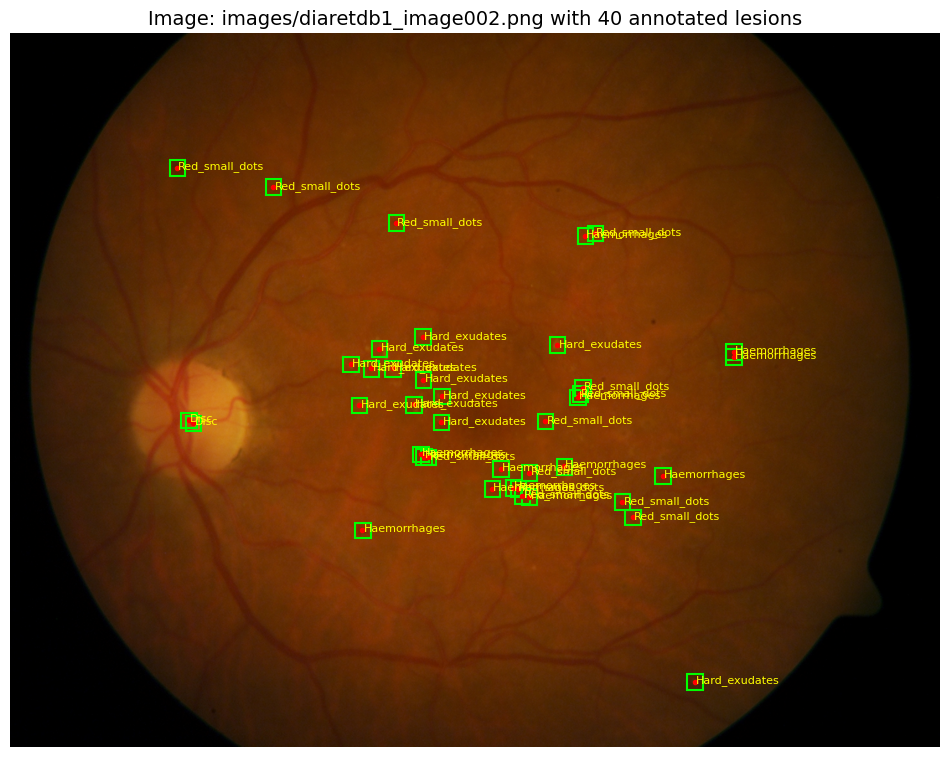

In [80]:
plot_lesion_annotations(image_rgb,
                        lesions,
                        title=f"Image: {single_entry['image']} with {len(lesions)} annotated lesions")


Now, if you look at the image, there still seems to be some duplicates, but they are much less than before. Adjusting the `eps` parameter can help to further reduce the number of annotations, but it might also lead to losing some valid annotations if set too high...

**We can discuss this on Monday...**

## Further Research

### Optic Disc

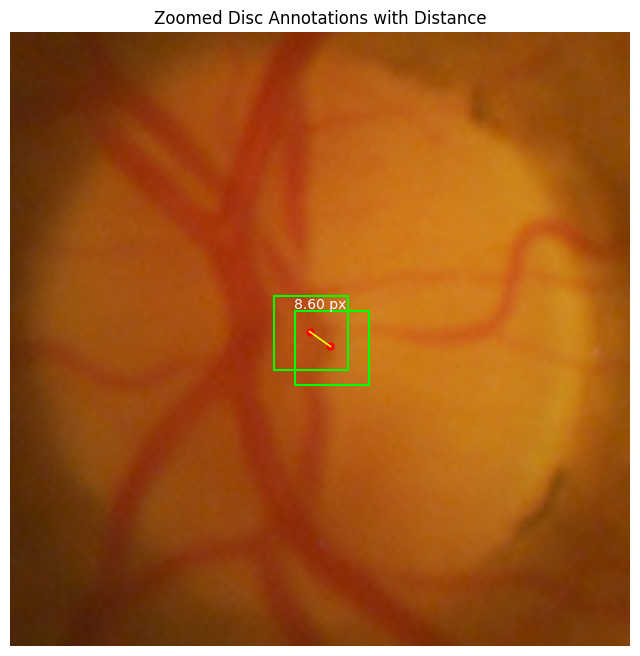

In [58]:
disc_lesions = [l for l in lesions if l["type"] == "Disc"]
if len(disc_lesions) != 2:
    raise ValueError("Expected exactly 2 disc lesions.")

(x1, y1), (x2, y2) = (int(disc_lesions[0]['x']), int(disc_lesions[0]['y'])), \
                    (int(disc_lesions[1]['x']), int(disc_lesions[1]['y']))
distance = np.linalg.norm([x2 - x1, y2 - y1])

plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)

for x, y in [(x1, y1), (x2, y2)]:
    rect = plt.Rectangle((x - PATCH_HALF, y - PATCH_HALF), PATCH_SIZE, PATCH_SIZE,
                         linewidth=1.5, edgecolor='lime', facecolor='none')
    plt.gca().add_patch(rect)
    plt.plot(x, y, 'ro', markersize=5)

plt.plot([x1, x2], [y1, y2], 'yellow', linewidth=1.2)
mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
plt.text(mid_x, mid_y - 10, f"{distance:.2f} px", color='white', fontsize=10, ha='center')

margin = 100
xmin, xmax = min(x1, x2) - margin, max(x1, x2) + margin
ymin, ymax = min(y1, y2) - margin, max(y1, y2) + margin
plt.xlim(xmin, xmax)
plt.ylim(ymax, ymin)

plt.title("Zoomed Disc Annotations with Distance")
plt.axis("off")
plt.show()


Now I know the optic disc will probably get removed, but this is here just to show you how small the margins are...even though it looks like a duplicate in the first plot, it's outside the `eps` radius, so it is not considered a duplicate by `DBSCAN`.

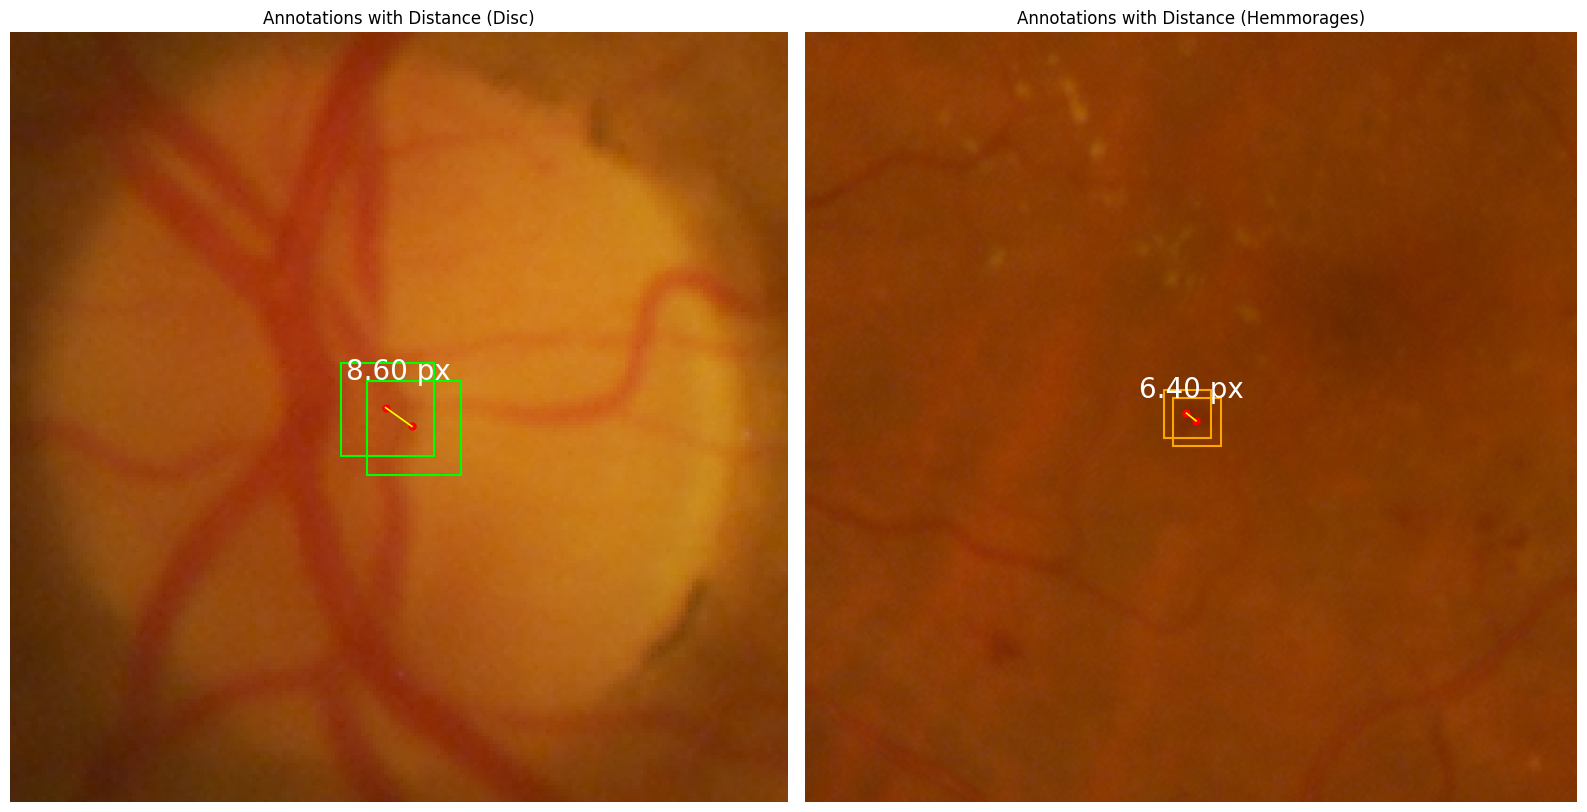

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# --- Subplot 1: Disc annotations ---
disc_lesions = [l for l in lesions if l["type"] == "Disc"]
(x1, y1), (x2, y2) = (int(disc_lesions[0]['x']), int(disc_lesions[0]['y'])), (int(disc_lesions[1]['x']), int(disc_lesions[1]['y']))
distance = np.linalg.norm([x2 - x1, y2 - y1])

axs[0].imshow(image_rgb)
for x, y in [(x1, y1), (x2, y2)]:
    rect = plt.Rectangle((x - PATCH_HALF, y - PATCH_HALF), PATCH_SIZE, PATCH_SIZE,
                         linewidth=1.5, edgecolor='lime', facecolor='none')
    axs[0].add_patch(rect)
    axs[0].plot(x, y, 'ro', markersize=5)

axs[0].plot([x1, x2], [y1, y2], 'yellow', linewidth=1.2)
mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
axs[0].text(mid_x, mid_y - 10, f"{distance:.2f} px", color='white', fontsize=20, ha='center')

margin = 100
xmin, xmax = min(x1, x2) - margin, max(x1, x2) + margin
ymin, ymax = min(y1, y2) - margin, max(y1, y2) + margin
axs[0].set_xlim(xmin, xmax)
axs[0].set_ylim(ymax, ymin)
axs[0].set_title("Annotations with Distance (Disc)")
axs[0].axis("off")

# --- Subplot 2: Close hemorrhages ---
ha1 = {'x': 662.0, 'y': 679.0, 'type': 'Haemorrhages'}
ha2 = {'x': 667.67, 'y': 683.33, 'type': 'Haemorrhages'}
(x1, y1), (x2, y2) = (int(ha1['x']), int(ha1['y'])), (int(ha2['x']), int(ha2['y']))
distance = np.linalg.norm([x2 - x1, y2 - y1])

axs[1].imshow(image_rgb)
for lesion in [ha1, ha2]:
    x, y = int(lesion["x"]), int(lesion["y"])
    rect = plt.Rectangle((x - PATCH_HALF, y - PATCH_HALF), PATCH_SIZE, PATCH_SIZE,
                         linewidth=1.5, edgecolor='orange', facecolor='none')
    axs[1].add_patch(rect)
    axs[1].plot(x, y, 'ro', markersize=5)

axs[1].plot([x1, x2], [y1, y2], 'yellow', linewidth=1.2)
mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
axs[1].text(mid_x, mid_y - 10, f"{distance:.2f} px", color='white', fontsize=20, ha='center')

margin = 200
xmin, xmax = min(x1, x2) - margin, max(x1, x2) + margin
ymin, ymax = min(y1, y2) - margin, max(y1, y2) + margin
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymax, ymin)
axs[1].set_title("Annotations with Distance (Hemmorages)")
axs[1].axis("off")

plt.tight_layout()
plt.show()


## Patch Extraction (RGB)

In [96]:
image_shape = image.shape[:2]  # (height, width)
patches = extract_patches(image_rgb, image_shape, lesions)
plot_patches(patches)


TypeError: plot_patches() missing 3 required positional arguments: 'image_rgb', 'image_shape', and 'lesions'

## Different Representations

### CLAHE

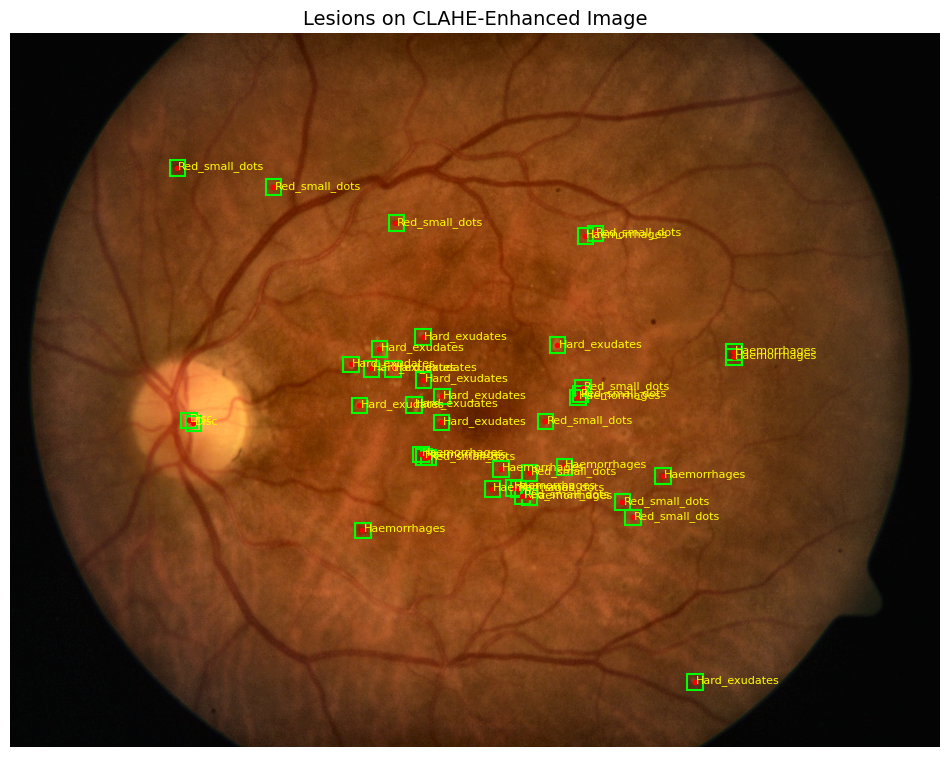

In [93]:
def generate_clahe_image(image_rgb):
    lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

clahe_image = generate_clahe_image(image_rgb)

plot_lesion_annotations(clahe_image, lesions, title="Lesions on CLAHE-Enhanced Image")


### Single Channel (R|G|B)

### Gray Scale

### HSV | LAB Color Spaces

### Edge/Texture Fillers